# Variational Quantum Eigensolver (VQE) wit Two Qubits

## Problem Setup

We will solve for the ground state energy of a simple 2-qubit Hamiltonian:

$
H = 1.0 * Z_0 + 0.5 * X_1
$

This is an artificial test Hamiltonian designed to demonstrate the Variational Quantum Eigensolver (VQE) algorithm in a pedagogical way.


In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Define the Hamiltonian

In [2]:
# Define Hamiltonian
coeffs = [1.0, 0.5]
obs = [qml.PauliZ(0), qml.PauliX(1)]

H = qml.Hamiltonian(coeffs, obs)

print("PennyLane Hamiltonian object:")
print(H)

PennyLane Hamiltonian object:
1.0 * Z(0) + 0.5 * X(1)


Get sparse matrix representation of the Hamiltonian.

In [3]:
# Returns a SciPy CSR sparse matrix
H_sparse = H.sparse_matrix()

print("SciPy Sparse Matrix (CSR):")
print(H_sparse)

SciPy Sparse Matrix (CSR):
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	(1+0j)
  (0, 1)	(0.5+0j)
  (1, 0)	(0.5+0j)
  (1, 1)	(1+0j)
  (2, 2)	(-1+0j)
  (2, 3)	(0.5+0j)
  (3, 2)	(0.5+0j)
  (3, 3)	(-1+0j)


In [4]:
# (Optional) Convert to dense to see full matrix
print("Dense matrix view:")
print(H_sparse.toarray())

Dense matrix view:
[[ 1. +0.j  0.5+0.j  0. +0.j  0. +0.j]
 [ 0.5+0.j  1. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -1. +0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j  0.5+0.j -1. +0.j]]


In [5]:
H_obs = qml.SparseHamiltonian(H_sparse, wires=[0, 1])
print("SparseHamiltonian ready for use in QNodes!")

SparseHamiltonian ready for use in QNodes!


## Ansatz Circuit

We use a simple hardware-efficient ansatz with 2 parameters:

- Single-qubit Ry rotations
- A CNOT entangling gate

In [6]:
# Define device
dev = qml.device('default.qubit', wires=2)

# Define the quantum circuit (ansatz)
@qml.qnode(dev)
def ansatz(params):  # A simple ansatz for 2 qubits
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    return qml.expval(H_obs)

Run a test circuit to verify the ansatz works.

In [7]:
test_params = np.array([0.1, 0.2])

expect_val = ansatz(test_params)
print("Expectation value of H on ansatz state:")
print(expect_val)

Expectation value of H on ansatz state:
1.0943388306755566


## Cost Function

The VQE cost is simply the expectation value of our Hamiltonian with respect to the ansatz state.

In [8]:
def cost_fn(params):
    return ansatz(params)

## Optimization

We minimize the cost function using a classical optimizer.

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)
params = np.array([0.5, -0.5], requires_grad=True)

steps = 50
energy_track = []

for i in range(steps):
    params, cost = opt.step_and_cost(cost_fn, params)
    energy_track.append(cost)
    
    if i % 10 == 0:
        print(f"Step {i:2d} | Energy = {cost:.6f}")


Step  0 | Energy = 0.637870
Step 10 | Energy = -0.976244
Step 20 | Energy = -1.486849
Step 30 | Energy = -1.499256
Step 40 | Energy = -1.499919


## Results

We plot the convergence of the variational energy.

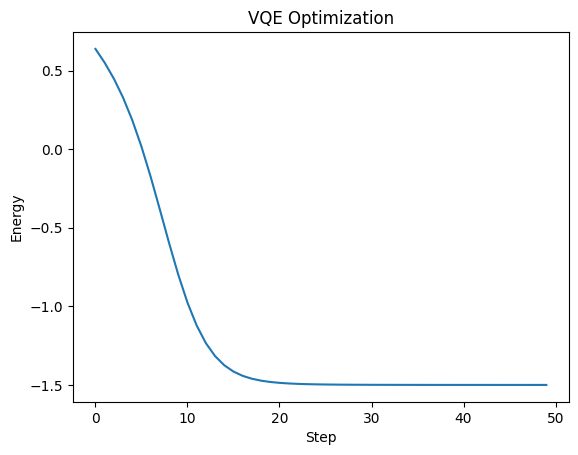

In [10]:
plt.plot(energy_track)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.title('VQE Optimization')
plt.show()

## Compare to Exact Solution

We can compute the exact ground state energy for our Hamiltonian:

In [11]:
# Convert the SparseHamiltonian to a dense matrix
dense_H = H_sparse.todense()

# Compute all eigenvalues
exact_eigenvalues, _ = np.linalg.eigh(dense_H)

# The smallest eigenvalue is the ground-state energy
exact_ground_energy = np.min(exact_eigenvalues)

print(f"Exact ground state energy: {exact_ground_energy:.6f}")
print(f"VQE estimated energy     : {energy_track[-1]:.6f}")


Exact ground state energy: -1.500000
VQE estimated energy     : -1.499988


## Conclusion

- We built a **simple 2-qubit Hamiltonian** with Pauli terms.
- We designed an **ansatz** with two parameters.
- We minimized the energy using **classical optimization**.
- We **compared** our result to the exact diagonalization.

This notebook shows the core idea of VQE **without chemistry complications**!